# Task Overview

Your task will be to implement a *RevNet* (Reversible Residual Network) – a variant of ResNet where each layer's activations can be reconstructed exactly from the next layer. Therefore, the activations for most layers need not be stored in memory to perform backpropagation.

You can find more information about RevNet here: [link](https://arxiv.org/pdf/1707.04585.pdf)

You should use an MLP architecture trained on the MNIST dataset. You should implement the network in numpy.

Tasks:
1. (10pt) Fill missing code below
  - 1pt implement the `__init__` method
  - 2pt implement the feedforward method
  - 2pt implement the mini-batch update
  - 5pt implement the backpropagation (note: if you implement backpropagation example-by-example instead of whole minibatch at once, you will get maximum of 2pt for this part)
2. Train the models (find proper hyperparameters). Visualize training of your best model (plot training and test loss/accuracy in time). Your model should reach at least 96% accuracy. Use clear ml for logging your scores. Make a comparison of memory usage for your network and the network you implemented in lab 3.
  - 1pt for accuracy above 96%
  - 1pt for visualizations (we recommend downloading plots from clear ml)
  - 2pt if [clear ml](https://clear.ml/docs/latest/docs/) used properly
  - 1pt for comparing memory usage.



## Potential questions, clarifications
- Q: Can I save the output of the last layer before classification (a -> 10)?
  - Yes.
- Q: MNIST has only one channel, how do I split that into two groups for implementing ReVNet blocks?
  - You can split activations into two groups, so if a layer has size $a$ you can split it into $2 \cdot a/2$.
- Q: Can I modify code of ReVNet outside #Your code goes here # to include logging?
  - Yes, in ReVNet.SGD

# Imports

In [1]:
!pip install clearml --quiet
!pip install memory-profiler --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.1 MB/s eta 0:00:00


In [2]:
import random
import numpy as np
from torchvision import datasets, transforms
from clearml import Task
import plotly.express as px

In [3]:
%load_ext memory_profiler

# Dataset loading


In [4]:
!wget -O mnist.npz https://s3.amazonaws.com/img-datasets/mnist.npz

--2023-12-14 21:42:15--  https://s3.amazonaws.com/img-datasets/mnist.npz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.165.160, 52.217.236.16, 52.217.94.134, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.165.160|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11490434 (11M) [application/octet-stream]
Saving to: ‘mnist.npz’

mnist.npz           100%[===================>]  10.96M  --.-KB/s    in 0.1s    

2023-12-14 21:42:15 (89.6 MB/s) - ‘mnist.npz’ saved [11490434/11490434]



In [5]:
def load_mnist(path='mnist.npz'):
    with np.load(path) as f:
        x_train, _y_train = f['x_train'], f['y_train']
        x_test, _y_test = f['x_test'], f['y_test']

    x_train = x_train.reshape(-1, 28 * 28) / 255.
    x_test = x_test.reshape(-1, 28 * 28) / 255.

    y_train = np.zeros((_y_train.shape[0], 10))
    y_train[np.arange(_y_train.shape[0]), _y_train] = 1

    y_test = np.zeros((_y_test.shape[0], 10))
    y_test[np.arange(_y_test.shape[0]), _y_test] = 1

    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_mnist()

# Set up clear ml

In [6]:
### Your code goes here ###
web_server = 'https://app.clear.ml'
api_server = 'https://api.clear.ml'
files_server = 'https://files.clear.ml'
access_key = ' XMAJ8ZTVRMCD2IVISVVN'#@param {type:"string"}
secret_key = '5fPbZJMLKp42EyAOZJg6rAWZICbqNtGR9POxuG7t37lg6z8AEY'#@param {type:"string"}

Task.set_credentials(web_host=web_server,
                     api_host=api_server,
                     files_host=files_server,
                     key=access_key,
                     secret=secret_key)
###########################

# Network definition (as in laboratory 3)


In [7]:
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    # Derivative of the sigmoid
    return sigmoid(z)*(1-sigmoid(z))

class Network(object):
    def __init__(self, sizes):
        # initialize biases and weights with random normal distr.
        # weights are indexed by target node first
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]
    def feedforward(self, a):
        # Run the network on a batch
        a = a.T
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.matmul(w, a)+b)
        return a

    def update_mini_batch(self, mini_batch, eta):
        # Update networks weights and biases by applying a single step
        # of gradient descent using backpropagation to compute the gradient.
        # The gradient is computed for a mini_batch which is as in tensorflow API.
        # eta is the learning rate
        nabla_b, nabla_w = self.backprop(mini_batch[0].T,mini_batch[1].T)

        self.weights = [w-(eta/len(mini_batch[0]))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch[0]))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        # For a single input (x,y) return a pair of lists.
        # First contains gradients over biases, second over weights.
        g = x
        gs = [g] # list to store all the gs, layer by layer
        fs = [] # list to store all the fs, layer by layer
        for b, w in zip(self.biases, self.weights):
            f = np.dot(w, g)+b
            fs.append(f)
            g = sigmoid(f)
            gs.append(g)
        # backward pass <- both steps at once
        dLdg = self.cost_derivative(gs[-1], y)
        dLdfs = []
        for w,g in reversed(list(zip(self.weights,gs[1:]))):
            dLdf = np.multiply(dLdg,np.multiply(g,1-g))
            dLdfs.append(dLdf)
            dLdg = np.matmul(w.T, dLdf)

        dLdWs = [np.matmul(dLdf,g.T) for dLdf,g in zip(reversed(dLdfs),gs[:-1])]
        dLdBs = [np.sum(dLdf,axis=1).reshape(dLdf.shape[0],1) for dLdf in reversed(dLdfs)]
        return (dLdBs,dLdWs)

    def evaluate(self, test_data):
        # Count the number of correct answers for test_data
        pred = np.argmax(self.feedforward(test_data[0]),axis=0)
        corr = np.argmax(test_data[1],axis=1).T
        return np.mean(pred==corr)

    def cost_derivative(self, output_activations, y):
        return (output_activations-y)

    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None):
        x_train, y_train = training_data
        if test_data:
            x_test, y_test = test_data
        for j in range(epochs):
            for i in range(x_train.shape[0] // mini_batch_size):
                x_mini_batch = x_train[(mini_batch_size*i):(mini_batch_size*(i+1))]
                y_mini_batch = y_train[(mini_batch_size*i):(mini_batch_size*(i+1))]
                self.update_mini_batch((x_mini_batch, y_mini_batch), eta)
            if test_data:
                print("Epoch: {0}, Accuracy: {1}".format(j, self.evaluate((x_test, y_test))))
            else:
                print("Epoch: {0}".format(j))


# ReVNet definition

RevNets are composed of a series of reversible blocks. The channels (in case of MNIST: activations) in each layer are partitioned into two groups (two vectors), denoted $x_1$ and $x_2$.

Forward: Each reversible block takes inputs ($x_1$, $x_2$) and produces outputs produces outputs ($y_1$, $y_2$) using functions F and G (the *residuals*). In this task, implement F and G as MLP layers.

$z_1 = x_1 + \mathcal{F}(x_2)$

$y_2 = x_2 + \mathcal{G}(z_1)$

$y_1 = z_1$

The expressions $y_1$ and $z_1$ have the same value, but they are separate nodes in the computation graph, with $y_2$ depending on $z_1$, not $y_1$. We use this distinction so that we can describe gradient computations in two steps: $∂ℒ/∂y_1$ is the derivative of the loss over $y_1$ when $y_2$ is a fixed constant, while $∂ℒ/∂z_1$ is the derivative over $z_1$, which influences the loss through both y1 and y2.

Reverse: Each layer’s activations can be reconstructed from the next layer’s activations as follows:

$x_2 = y_2 - \mathcal{G}(y_1)$

$x_1 = y_1 - \mathcal{F}(x_2)$

Backpropagation is described in the algorithm below, ($y_1$, $y_2$).
$\bar{y_1}$, $\bar{y_2}$ is the gradient of the loss over $y_1$ and $y_2$, respectively


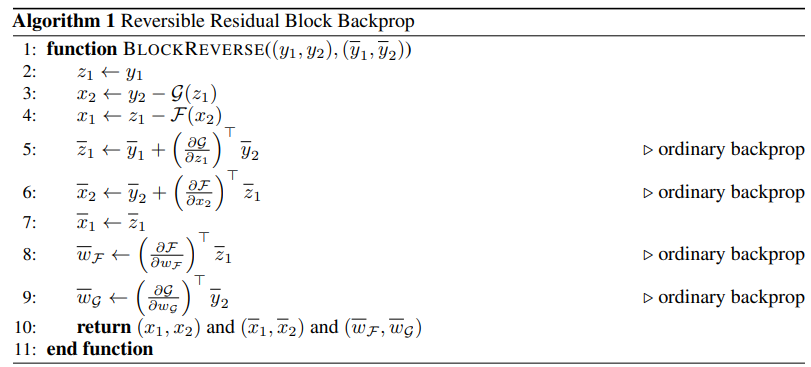

In [8]:
def softmax(x):
    ### Your code goes here ###
    exp = np.exp(x - np.max(x, axis = 0))
    return exp/np.sum(exp, axis = 0)
    ###########################

def cross_entropy(x, y):
    ### Your code goes here ###
    eps = 1e-16
    x = np.clip(eps, x, 1-eps)
    return -((y * np.log(x)).sum(axis=0)).mean()
    ###########################

class ReVNet(object):
  def __init__(self, sizes):
    self.sizes = sizes
    # initialize biases and weights with random normal distr.
    # weights are indexed by target node first
    # sizes should be in form (mnist_size, a, a, a, ...,  a, 10)
    # IMPORTANT: use at least one layer of size a -> a
    ### Your code goes here ###
    self.num_layers = len(sizes)
    self.sizes = sizes
    self.first_layer_weights = np.random.randn(sizes[1], sizes[0])
    self.first_layer_biases = np.random.randn(sizes[1], 1)
    self.last_layer_weights = np.random.randn(sizes[len(sizes) - 1], sizes[len(sizes) - 2])
    self.last_layer_biases = np.random.randn(sizes[len(sizes) - 1], 1)
    self.biasesF = [np.random.randn(int(y/2), 1) for y in sizes[2:-1]]
    self.biasesG = [np.random.randn(int(y/2), 1) for y in sizes[2:-1]]
    self.weightsF = [np.random.randn(int(y/2), int(x/2)) for x, y in zip(sizes[1:-2], sizes[2:-1])]
    self.weightsG = [np.random.randn(int(y/2), int(x/2)) for x, y in zip(sizes[1:-2], sizes[2:-1])]
    ###########################

  def feedforward(self, a):
    # Run the network
    ### Your code goes here ###
    a = a.T
    a = sigmoid(np.matmul(self.first_layer_weights, a) + self.first_layer_biases)
    len  = int(a.shape[0]/2)
    x1 = a[:len, :]
    x2 = a[len:, :]
    for bf, wf, bg, wg in zip(self.biasesF, self.weightsF, self.biasesG, self.weightsG):
        y1 = x1 + sigmoid(np.matmul(wf, x2)+bf)
        y2 = x2 + sigmoid(np.matmul(wg, y1)+bg)
        x1 = y1
        x2 = y2
    x = np.concatenate([x1, x2], axis = 0)
    wynik = softmax(np.matmul(self.last_layer_weights, x) + self.last_layer_biases)
    return wynik
    ###########################

  def update_mini_batch(self, x_mini_batch, y_mini_batch, eta):
    # Update networks weights and biases by applying a single step
    # of gradient descent using backpropagation to compute the gradient.
    # The gradient is computed for a mini_batch.
    # eta is the learning rate
    ### Your code goes here ###
    nabla_b_first, nabla_w_first, nabla_bf, nabla_wf, nabla_bg, nabla_wg, nabla_b_last, nabla_w_last = self.backpropagation(x_mini_batch, y_mini_batch)

    eta = eta/len(x_mini_batch)

    self.first_layer_biases = self.first_layer_biases - eta * nabla_b_first
    self.first_layer_weights = self.first_layer_weights - eta * nabla_w_first
    self.last_layer_biases = self.last_layer_biases - eta * nabla_b_last
    self.last_layer_weights = self.last_layer_weights - eta * nabla_w_last

    self.weightsF = [w - eta * nw for w, nw in zip(self.weightsF, nabla_wf)]
    self.weightsG = [w - eta * nw for w, nw in zip(self.weightsG, nabla_wg)]
    self.biasesF = [w - eta * nw for w, nw in zip(self.biasesF, nabla_bf)]
    self.biasesg = [w - eta * nw for w, nw in zip(self.biasesG, nabla_bg)]
    ###########################


  def backpropagation(self, x, y):
    ### Your code goes here ###
    #forward pass
    x = x.T
    y = y.T

    first_layer_output = sigmoid(self.first_layer_weights @ x + self.first_layer_biases)
    x1 = first_layer_output[:int(first_layer_output[:,0].size/2), :]
    x2 = first_layer_output[int(first_layer_output[:,0].size/2):, :]

    x1s_testing_forward = []
    x2s_testing_forward = []

    for bf, wf, bg, wg in zip(self.biasesF, self.weightsF, self.biasesG, self.weightsG):
        x1s_testing_forward = [x1] + x1s_testing_forward
        x2s_testing_forward = [x2] + x2s_testing_forward

        y1 = x1 + sigmoid(np.matmul(wf, x2)+bf)
        y2 = x2 + sigmoid(np.matmul(wg, y1)+bg)
        x1 = y1
        x2 = y2




    last_revnet_layer_output = np.concatenate([x1, x2], axis = 0)
    output = softmax(self.last_layer_weights @ last_revnet_layer_output + self.last_layer_biases)

    dldf = self.cost_derivative(output, y)
    nabla_w_last = dldf @ last_revnet_layer_output.T
    nabla_b_last = np.expand_dims(np.sum(dldf, axis = 1), axis = 1)

    #hidden layers

    nabla_wf = []
    nabla_wg = []
    nabla_bf = []
    nabla_bg = []

    dldg2 = self.last_layer_weights.T @ dldf

    dldy1 = dldg2[: int(last_revnet_layer_output[:,0].size/2) , :]
    dldy2 = dldg2[int(last_revnet_layer_output[:,0].size/2) : , :]
    y1 = last_revnet_layer_output[: int(last_revnet_layer_output[:,0].size/2) , :]
    y2 = last_revnet_layer_output[int(last_revnet_layer_output[:,0].size/2) : , :]

    for wg, wf, bg, bf in reversed(list(zip(self.weightsG, self.weightsF, self.biasesG, self.biasesF))):
      z1 = y1
      x2 = y2 - sigmoid(wg @ z1 + bg)
      x1 = z1 - sigmoid(wf @ x2 + bf)

      dldz1 = dldy1 + sigmoid_prime(wg @ z1 + bg) * (wg.T @ dldy2)
      dldx2 = dldy2 + sigmoid_prime(wf @ x2 + bf) * (wf.T @ dldz1)
      dldx1 = dldz1

      dldwf = (dldz1 * sigmoid_prime(wf @ x2 + bf)) @ x2.T
      dldwg = (dldy2 * sigmoid_prime(wg @ z1 + bg)) @ z1.T
      dldbf = np.expand_dims(np.sum(sigmoid_prime(wf @ x2 + bf) * dldz1, axis = 1), axis = 1)
      dldbg = np.expand_dims(np.sum(sigmoid_prime(wg @ z1 + bg) * dldy2, axis = 1), axis = 1)

      y1 = x1
      y2 = x2
      dldy1 = dldx1
      dldy2 = dldx2

      nabla_wf = [dldwf] + nabla_wf
      nabla_wg = [dldwg] + nabla_wg
      nabla_bf = [dldbf] + nabla_bf
      nabla_bg = [dldbg] + nabla_bg

    dldf_last = sigmoid_prime(self.first_layer_weights @ x + self.first_layer_biases) * np.concatenate((dldx1, dldx2), axis = 0)

    nabla_w_first = dldf_last @ x.T
    nabla_b_first = np.expand_dims(np.sum(dldf_last, axis = 1), axis = 1)

    return nabla_b_first, nabla_w_first, nabla_bf, nabla_wf, nabla_bg, nabla_wg, nabla_b_last, nabla_w_last
    ###########################

  def cost_derivative(self, output_activations, y):
    return (output_activations-y)

  def evaluate(self, x_test_data, y_test_data):
      # Count the number of correct answers for test_data
        pred = np.argmax(self.feedforward(x_test_data),axis=0)
        corr = np.argmax(y_test_data,axis=1).T
        return np.mean(pred==corr)


  def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None, logger = None):
      x_train, y_train = training_data
      if test_data:
          x_test, y_test = test_data
      for j in range(epochs):
          for i in range(x_train.shape[0] // mini_batch_size):
              x_mini_batch = x_train[i*mini_batch_size:(i*mini_batch_size + mini_batch_size)]
              y_mini_batch = y_train[i*mini_batch_size:(i*mini_batch_size + mini_batch_size)]
              self.update_mini_batch(x_mini_batch, y_mini_batch, eta)
          if test_data:
              test_accuracy = self.evaluate(x_test, y_test)
              train_accuracy = self.evaluate(x_train, y_train)
              test_loss = cross_entropy(self.feedforward(x_test), y_test.T)
              train_loss = cross_entropy(self.feedforward(x_train), y_train.T)
              print("Epoch: {0}, Accuracy: {1}".format(j, test_accuracy))
              if logger != None:
                logger.report_scalar(title='Accuracy', series='Test', iteration=j, value=test_accuracy)
                logger.report_scalar(title='Accuracy', series='Train', iteration=j, value=train_accuracy)
                logger.report_scalar(title='Loss', series='Train', iteration=j, value=train_loss)
                logger.report_scalar(title='Loss', series='Test', iteration=j, value=test_loss)
          else:
              print("Epoch: {0}".format(j))

# Train the network

In [11]:
 ### Your code goes here ###

baseline_config = {'epochs': 20, 'mini_batch_size': 80, 'eta': 1.1, 'sizes': [784, 30, 30, 30, 30, 10]}

def train_and_log_with_clear_ml(x_train = x_train, y_train = y_train, epochs=baseline_config['epochs'], mini_batch_size=baseline_config['mini_batch_size'], \
                                eta=baseline_config['eta'], test_data=(x_test, y_test), sizes = baseline_config['sizes']):
  #print('eta = ', eta)
  config = {'epochs': epochs, 'mini_batch_size': mini_batch_size, 'eta': eta, 'sizes': sizes}
  #print('eta = ', config['eta'], 'sizes = ', config['sizes'])
  task = Task.create(project_name='GSN HW1 Rev-Net', task_name='Rev_net manual logging')
  task.mark_started()
  logger = task.get_logger()
  task.connect(config)
  network = ReVNet(sizes)
  network.SGD((x_train, y_train), epochs, mini_batch_size, eta, test_data=(x_test, y_test), logger = logger)
  task.mark_completed()
  task.close()

train_and_log_with_clear_ml()
###########################

Epoch: 0, Accuracy: 0.8629
Epoch: 1, Accuracy: 0.8917
Epoch: 2, Accuracy: 0.9062
Epoch: 3, Accuracy: 0.9154
Epoch: 4, Accuracy: 0.9197
Epoch: 5, Accuracy: 0.9227
Epoch: 6, Accuracy: 0.9257
Epoch: 7, Accuracy: 0.9268
Epoch: 8, Accuracy: 0.928
Epoch: 9, Accuracy: 0.9284
Epoch: 10, Accuracy: 0.9292
Epoch: 11, Accuracy: 0.9296
Epoch: 12, Accuracy: 0.9291
Epoch: 13, Accuracy: 0.9302
Epoch: 14, Accuracy: 0.9313
Epoch: 15, Accuracy: 0.933
Epoch: 16, Accuracy: 0.9349
Epoch: 17, Accuracy: 0.9351
Epoch: 18, Accuracy: 0.9356
Epoch: 19, Accuracy: 0.9344


# Training plots for the best training

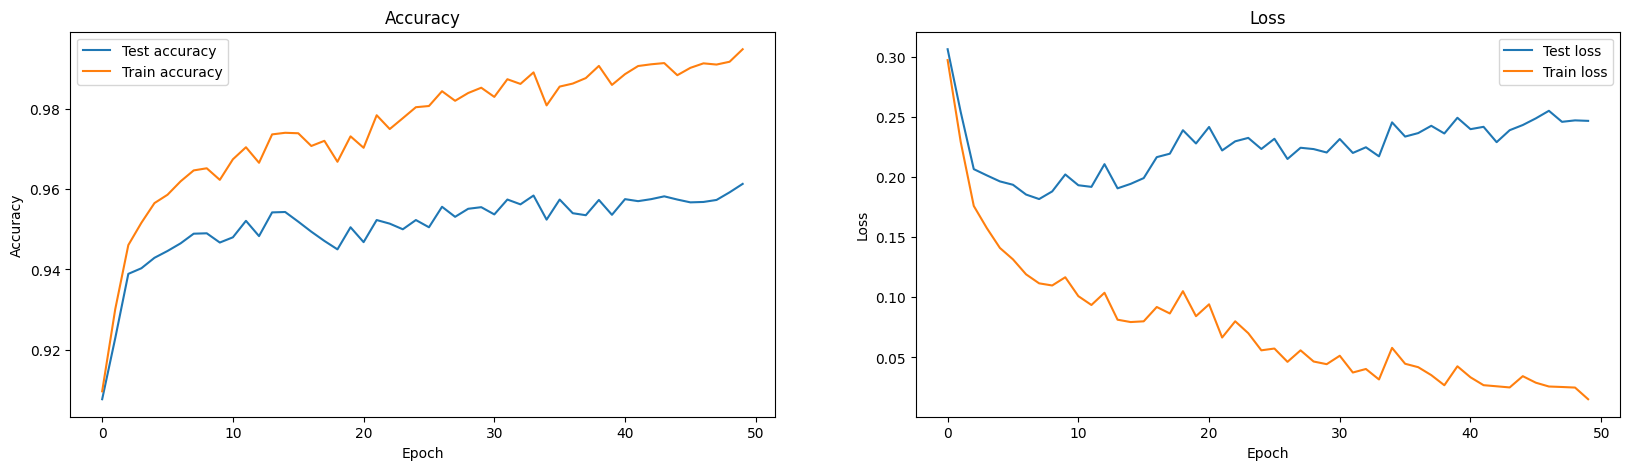

In [12]:
 ### Your code goes here ###
import matplotlib.pyplot as plt
plot_info = Task.get_tasks(
    project_name='GSN HW1 Rev-Net',
    tags=["Best"]
)

assert len(plot_info) == 1;

task = plot_info[0]

metrics = task.get_reported_scalars()

# Create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

# Plot some data on each subplot
ax1.plot(metrics['Accuracy']['Test']['x'], metrics['Accuracy']['Test']['y'])
ax1.plot(metrics['Accuracy']['Train']['x'], metrics['Accuracy']['Train']['y'])
ax1.legend(['Test accuracy', 'Train accuracy'])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy')

ax2.plot(metrics['Loss']['Test']['x'], metrics['Loss']['Test']['y'])
ax2.plot(metrics['Loss']['Train']['x'], metrics['Loss']['Train']['y'])
ax2.legend(['Test loss', 'Train loss'])
ax2.set_title('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
plt.show()

###########################

Here, it the last epoch, model achives 96.13% accuracy.

In [14]:
for x, y in zip(metrics['Accuracy']['Test']['x'], metrics['Accuracy']['Test']['y']):
  print('Epoch = ', x, ' accuracy = ', y)

Epoch =  0  accuracy =  0.9077000021934509
Epoch =  1  accuracy =  0.9229000210762024
Epoch =  2  accuracy =  0.9388999938964844
Epoch =  3  accuracy =  0.9402999877929688
Epoch =  4  accuracy =  0.9429000020027161
Epoch =  5  accuracy =  0.944599986076355
Epoch =  6  accuracy =  0.9465000033378601
Epoch =  7  accuracy =  0.9488999843597412
Epoch =  8  accuracy =  0.9490000009536743
Epoch =  9  accuracy =  0.9466999769210815
Epoch =  10  accuracy =  0.9480000138282776
Epoch =  11  accuracy =  0.9520999789237976
Epoch =  12  accuracy =  0.9483000040054321
Epoch =  13  accuracy =  0.954200029373169
Epoch =  14  accuracy =  0.9542999863624573
Epoch =  15  accuracy =  0.9519000053405762
Epoch =  16  accuracy =  0.949400007724762
Epoch =  17  accuracy =  0.9470999836921692
Epoch =  18  accuracy =  0.9449999928474426
Epoch =  19  accuracy =  0.9505000114440918
Epoch =  20  accuracy =  0.9467999935150146
Epoch =  21  accuracy =  0.9523000121116638
Epoch =  22  accuracy =  0.9513999819755554
E

# Compare memory usage

Hint: you can use memory-profiler library [link](https://pypi.org/project/memory-profiler/)

In [13]:
 ### Your code goes here ###
network_for_memory_comparison = Network(baseline_config['sizes']) #normal MLP for memory comparison
%memit train_and_log_with_clear_ml()
%memit network_for_memory_comparison.SGD((x_train, y_train), baseline_config['epochs'], baseline_config['mini_batch_size'], baseline_config['eta'], test_data=(x_test, y_test))
###########################

Epoch: 0, Accuracy: 0.8544
Epoch: 1, Accuracy: 0.8884
Epoch: 2, Accuracy: 0.9029
Epoch: 3, Accuracy: 0.9127
Epoch: 4, Accuracy: 0.9194
Epoch: 5, Accuracy: 0.9239
Epoch: 6, Accuracy: 0.9267
Epoch: 7, Accuracy: 0.9276
Epoch: 8, Accuracy: 0.9295
Epoch: 9, Accuracy: 0.9315
Epoch: 10, Accuracy: 0.9325
Epoch: 11, Accuracy: 0.9338
Epoch: 12, Accuracy: 0.9338
Epoch: 13, Accuracy: 0.9346
Epoch: 14, Accuracy: 0.9351
Epoch: 15, Accuracy: 0.9359
Epoch: 16, Accuracy: 0.9363
Epoch: 17, Accuracy: 0.9364
Epoch: 18, Accuracy: 0.9377
Epoch: 19, Accuracy: 0.9392
peak memory: 1151.54 MiB, increment: 53.94 MiB
Epoch: 0, Accuracy: 0.7002
Epoch: 1, Accuracy: 0.8015
Epoch: 2, Accuracy: 0.8404
Epoch: 3, Accuracy: 0.8613
Epoch: 4, Accuracy: 0.8761
Epoch: 5, Accuracy: 0.8844
Epoch: 6, Accuracy: 0.8906
Epoch: 7, Accuracy: 0.8972
Epoch: 8, Accuracy: 0.9028
Epoch: 9, Accuracy: 0.9061
Epoch: 10, Accuracy: 0.9095
Epoch: 11, Accuracy: 0.9128
Epoch: 12, Accuracy: 0.9154
Epoch: 13, Accuracy: 0.9173
Epoch: 14, Accuracy: 